In [85]:
source('utils.r')
source('selinf_functions.r')
source('metrics.r')
source('data_generator.r')
source('cov_matrix.r')
source('minMod_modif.r')

## Simulating random time
In this example we simulate data from a certain number of subjects and assume that time (introduced as a dummy variable) has a random effect. The rest of the computation is the same as before.

In [86]:
set.seed(10)

n_subjects= 25
n_observations = 4
n = n_subjects * n_observations
p = 100
q <- n_observations-1
SNR = 4
prop_relevant = 0.1

data <- data_generator_random_time(n_subjects, n_observations, p, SNR, prop_relevant, rho=0.5)
X <- data$X
Z <- data$Z
subjects <- data$subjects
y <- data$y
beta <- data$beta
sd <- data$sd

Warning message in cov2cor(Psi):
"diag(.) had 0 or NA entries; non-finite result is doubtful"


Redundant covariance parameters. 
|activeSet|>=min(p,ntot): Increase lambda or set stopSat=FALSE. 


Warning message in cov2cor(Psi):
"diag(.) had 0 or NA entries; non-finite result is doubtful"


Redundant covariance parameters. 
|activeSet|>=min(p,ntot): Increase lambda or set stopSat=FALSE. 
[1] 10.4128


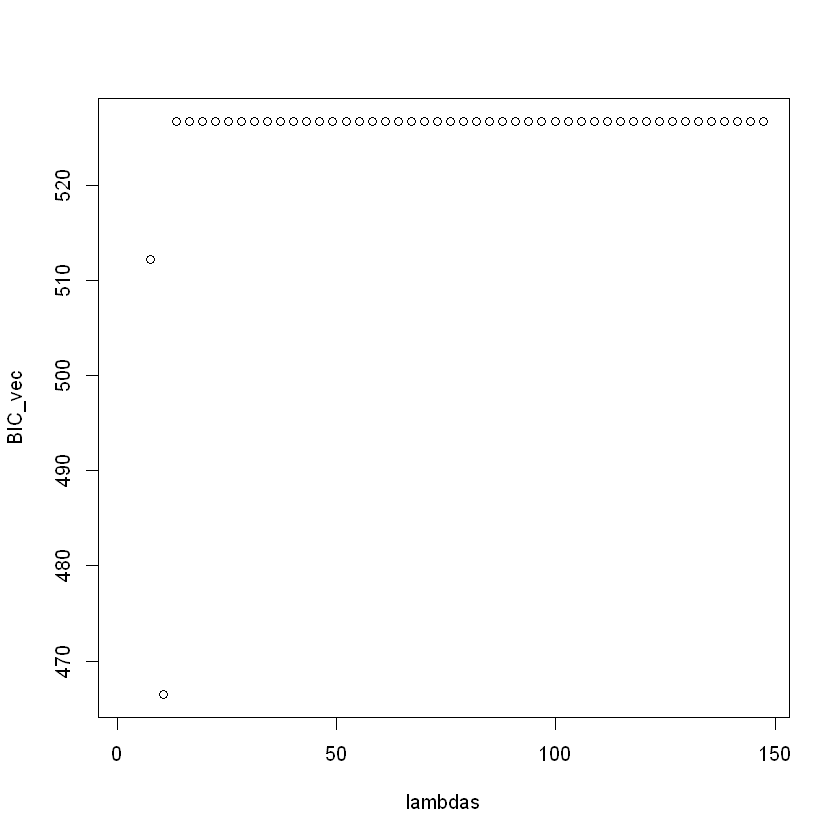

In [88]:
lambda.max.min.ratio = 0.01
n_lambdas = 50
lambda_max <- max(abs(t(X) %*% y))
plotting = TRUE
lambdas <- linspace(lambda_max,lambda_max*lambda.max.min.ratio, n=n_lambdas)
BIC_vec<-rep(Inf,length(lambdas))

for(j in 1:length(lambdas))
{

lasso_res <- lmmlasso(cbind(rep(1,n),X),y,cbind(rep(1,n),Z),subjects,lambda=lambdas[j],nonpen = c(1:4))
BIC_vec[j]<-lasso_res$bic
}

if(plotting) plot(lambdas,BIC_vec)

opt<-which.min(BIC_vec)

print(lambdas[opt])

lasso_res <- lmmlasso(cbind(rep(1,n),X),y,cbind(rep(1,n),Z),subjects,lambda=lambdas[opt],nonpen = c(1:4))

In [105]:
## Fixed lambda

lambda = 10

selFun <- function(y) selFun_fixed_lambda_randtime(X, Z, subjects, y, lambda)

sel <- selFun(y)
sel_vec <- sel$vec
sel_names <- sel$names
print(metrics(sel_vec,c(TRUE,beta!=0)))

$tpr
[1] 1

$fdr
[1] 0.6888889



In [100]:
## Adding Selective Inference
# Now we can define the function checking the congruency
# with the original selection
checkFun <- function(yb){

  all(selFun(yb)$vec == sel_vec)

}

sel_form = as.formula(
  paste("y ~ ",paste(sel_names[2:length(sel_names)], collapse='+'), "+ (t1 + t2 +t3|subjects)")
)

control <- lmerControl(
    check.nobs.vs.rankZ = "ignore",
    check.nobs.vs.nlev = "ignore",
    check.nlev.gtreq.5 = "ignore",
    check.nlev.gtr.1 = "ignore",
    check.nobs.vs.nRE= "ignore",
)


final_model = lmer(formula = sel_form, control= control ,data=data.frame(X, subjects, y))

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"unable to evaluate scaled gradient"
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge: degenerate  Hessian with 1 negative eigenvalues"
Warning message:
"Model failed to converge with 1 negative eigenvalue: -4.8e-04"


In [94]:
suppressWarnings(res <- mocasin(final_model, this_y = y, conditional = FALSE,
               checkFun = checkFun, nrSamples = 50))

Computing inference for variable (location)  1 

  |                                                                      |   0%

  |======================================================================| 100%


Computing inference for variable (location)  2 

  |======================================================================| 100%


Computing inference for variable (location)  3 

  |======================================================================| 100%


Computing inference for variable (location)  4 

  |======================================================================| 100%


Computing inference for variable (location)  5 

  |======================================================================| 100%


Computing inference for variable (location)  6 

  |======================================================================| 100%


Computing inference for variable (location)  7 

  |======================================================================| 100%


Computing inference for variable (location)  8 

  |======================================================================| 100%


C

In [95]:
# create a boolean vector for the ones selected controlling fdr level with BH procedure

sel_with_selinf <- selection_with_selinf(res, sel_vec, fdr_level = 0.1)
metrics(sel_with_selinf,c(1,beta!=0))

$tpr
[1] 0.9285714

$fdr
[1] 0.1333333